Формулы для градиентов, здесь $n$ - количество скрытых слоев, $X$ - данные, $E$ - единичная матрица, $a_i$ - результат $i$-того слоя, "$\cdot$" - поэлементное умножение, "$\circ$" - обычное умножение матриц.

Для последнего слоя:
$$dz_n = dL \cdot a_n \cdot (E - a_n)$$
$$dw_n = dL^T \circ a_{n-1}$$
$$db_n = dL^T \circ E$$
Для $i$-того слоя, $i \in (1, n)$
$$dz_i = (dz_{i+1} \circ w_{i+1}) \cdot \frac{\partial a_{i}}{\partial z_{i}}$$
$$dw_i = dz_i^T \circ a_{i-1}$$
$$db_i = dz_i^T \circ E$$
Для первого слоя
$$dz_1 = (dz_2 \circ w_2) \cdot \frac{\partial \sigma_1}{\partial z_1}$$
$$dw_1 = dz_1 \circ X$$
$$db_1 = dz_1 \circ E$$

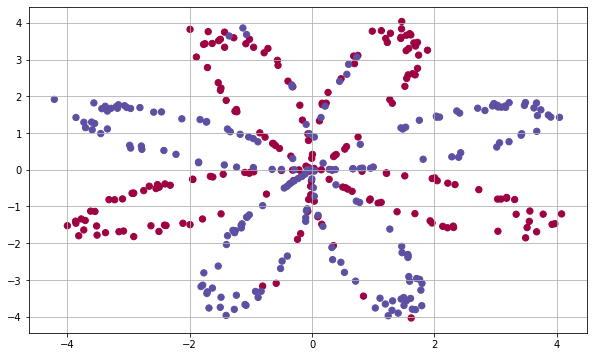

In [2]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import os

def load_planar_dataset(m=400):
    np.random.seed(1)
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    return X, Y

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    X = X.T
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

X, Y = load_planar_dataset() 
plt.figure(figsize=(10,6))
plt.grid()
plt.scatter(X[:,0], X[:,1], c=Y[:,0], s=40, cmap=plt.cm.Spectral);

In [3]:
class NLayersNN:
    def __init__(self, n_input, n_hidden, activation_funs):
        self.layers = len(n_hidden) + 1
        self.params = {f'w{i+1}': None for i in range(self.layers)}
        params_tmp = {f'b{i+1}': None for i in range(self.layers)}
        self.params.update(params_tmp)
        
        self.gradients = {f'dw{i+1}': None for i in range(self.layers)}
        gradients_tmp = {f'db{i+1}': None for i in range(self.layers)}
        self.gradients.update(gradients_tmp)
        gradients_tmp = {f'dz{i+1}': None for i in range(self.layers)}
        self.gradients.update(gradients_tmp)
        
        self.cache = {f'z{i+1}': None for i in range(self.layers)}
        cache_tmp = {f'a{i+1}': None for i in range(self.layers)}
        self.cache.update(cache_tmp)
        self.cache.update({'X': None})
        
        self.ew_avg = {f'Vb{i+1}': 0 for i in range(self.layers)}
        ew_avg_tmp = {f'Vw{i+1}': 0 for i in range(self.layers)}
        self.ew_avg.update(ew_avg_tmp)

        self._initialize_params(n_input, n_hidden)
        self._initialize_activations(activation_funs)
        

    def _initialize_params(self, n_input, n_hidden): 
        self.params['w1'] = np.random.randn(n_hidden[0], n_input)
        self.params['b1'] = np.zeros((n_hidden[0],))
        for i in range(1, self.layers - 1):
          self.params[f'w{i+1}'] = np.random.randn(n_hidden[i], n_hidden[i-1])
          self.params[f'b{i+1}'] = np.zeros((n_hidden[i],))
        self.params[f'w{self.layers}'] = np.random.randn(1, n_hidden[self.layers - 2])
        self.params[f'b{self.layers}'] = np.zeros((1,))

        for key in self.params.keys():
            self.gradients['d' + key] = np.zeros_like(self.params[key])
            
    
    def _initialize_activations(self, activation_funs):
        self.__dict__['activation'] = []
        self.__dict__['activation_backward'] = []
        for i,act in enumerate(activation_funs):
            if act == "tanh":
                self.activation.append(np.tanh)
                self.activation_backward.append(lambda x: 1 - np.tanh(x)**2)
            if act == "sigmoid":
                self.activation.append(self.sigmoid)
                self.activation_backward.append(lambda x: self.sigmoid(x)*(1.-self.sigmoid(x)))


    @staticmethod
    def sigmoid(z):
        return np.where(
            z >= 0,
            1 / (1 + np.exp(-z)), 
            np.exp(z) / (1 + np.exp(z))
        )

    def collect_cache(self, **kwargs):
        for key in kwargs.keys():
            self.cache[key] = kwargs[key]
            
    def collect_grads(self, **kwargs):
        for key in kwargs.keys():
            self.gradients[key] = kwargs[key]
    
    def unpack_cache(self, keys):
        output = []
        for key in keys:
            output.append(self.cache[key])
        output = tuple(output)
        return output

    def forward(self, X):
        """Method for forward pass implementation
        
        Input:
            X - matrix of input data, shape (n, n_features)
        
        Output:
            computed logistic regression of X
        """
        self.cache['z1'] = X @ self.params['w1'].T + self.params['b1']
        self.cache['a1'] = self.activation[0](self.cache['z1'])
        
        for i in range(1, self.layers):
          self.cache[f'z{i+1}'] = self.cache[f'a{i}'] @ self.params[f'w{i+1}'].T + self.params[f'b{i+1}']
          self.cache[f'a{i+1}'] = self.activation[i](self.cache[f'z{i+1}'])

        self.cache['X'] = X

        return self.cache[f'a{self.layers}']
    
    def __call__(self, X):
        return self.forward(X)

    def backward(self, dL):
        keys_z = []
        keys_a = []
        for i in range(0, self.layers):
          keys_z.append(f'z{i+1}')
          keys_a.append(f'a{i+1}')
        
        z = self.unpack_cache(keys_z)
        a = self.unpack_cache(keys_a)
        X = self.cache['X']

        dz = [None for i in range(self.layers)]
        dw = [None for i in range(self.layers)]
        db = [None for i in range(self.layers)]

        dz[self.layers - 1] = dL * (a[self.layers - 1]*(1. - a[self.layers - 1]))
        dw[self.layers - 1] = dL.T @ a[self.layers - 2]
        db[self.layers - 1] = dL.T @ np.ones((z[self.layers - 1].shape[0]))

        for i in range(self.layers - 2, 0, -1):
          dz[i] = (dz[i+1] @ self.params[f'w{i+2}'])*self.activation_backward[i+1](z[i])
          dw[i] = (dz[i].T @ a[i-1])
          db[i] = dz[i].T @ np.ones(z[i-1].shape[0])

        dz[0] = (dz[1] @ self.params['w2'])*self.activation_backward[1](z[0])
        dw[0] = (dz[0].T @ X)
        db[0] = dz[0].T @ np.ones(X.shape[0])

        for i in range(1, self.layers):
          self.gradients[f'dw{i+1}'] = dw[i]
          self.gradients[f'db{i+1}'] = db[i]

    
    def backward_momentum(self, dL, beta):
        keys_z = []
        keys_a = []
        keys_Vb = []
        keys_Vw = []
        for i in range(0, self.layers):
          keys_z.append(f'z{i+1}')
          keys_a.append(f'a{i+1}')
          keys_Vb.append(f'Vb{i+1}')
          keys_Vw.append(f'Vw{i+1}')
        
        z = self.unpack_cache(keys_z)
        a = self.unpack_cache(keys_a)
        X = self.cache['X']

        dz = [None for i in range(self.layers)]
        dw = [None for i in range(self.layers)]
        db = [None for i in range(self.layers)]

        dz[self.layers - 1] = dL * (a[self.layers - 1]*(1. - a[self.layers - 1]))
        dw[self.layers - 1] = dL.T @ a[self.layers - 2]
        db[self.layers - 1] = dL.T @ np.ones((z[self.layers - 1].shape[0]))

        for i in range(self.layers - 2, 0, -1):
          dz[i] = (dz[i+1] @ self.params[f'w{i+2}'])*self.activation_backward[i+1](z[i])
          dw[i] = (dz[i].T @ a[i-1])
          db[i] = dz[i].T @ np.ones(z[i-1].shape[0])

        dz[0] = (dz[1] @ self.params['w2'])*self.activation_backward[1](z[0])
        dw[0] = (dz[0].T @ X)
        db[0] = dz[0].T @ np.ones(X.shape[0])

        for i in range(1, self.layers):
          self.ew_avg[f'Vb{i+1}'] = beta*self.ew_avg[f'Vb{i+1}'] + (1 - beta)*db[i]
          self.ew_avg[f'Vw{i+1}'] = beta*self.ew_avg[f'Vw{i+1}'] + (1 - beta)*dw[i]
          self.gradients[f'dw{i+1}'] = dw[i]
          self.gradients[f'db{i+1}'] = db[i]



    def summary(self):
        num_layers = len(self.params)//2
        for i in range(1, num_layers + 1):
            w_ind, b_ind = f'w{i}', f'b{i}'
            print(f"Layer_{i}\t weights shape: {self.params[w_ind].shape}\t bias shape: {self.params[b_ind].shape}")


Оптимизатор: алгоритм momentum, mini-batch GD

In [4]:
class Optimizer:
    def __init__(self, regression_class, batch_amnt, lr=1e-2):
        self.model = regression_class
        self.lr = lr
        self.batch_amnt = batch_amnt
        self.batches = [None for i in range(batch_amnt)]
        self.y_batches = [None for i in range(batch_amnt)]
        
    def step(self):
        new_params = {
            k: None for k in self.model.params
        }
        params = self.model.params
        grads = self.model.gradients
        
        for key in self.model.params.keys():
            new_params[key] = params[key] - self.lr*grads["d"+key]
        self.model.params = new_params
        
    
    def step_momentum(self):
        new_params = {
            k: None for k in self.model.params
        }
        params = self.model.params
        ew_avg = self.model.ew_avg
        
        for key in self.model.params.keys():
            new_params[key] = params[key] - self.lr*ew_avg["V"+key]
        self.model.params = new_params

    def zero_grad(self):
        for key in self.model.gradients.keys():
            self.model.gradients[key] = np.zeros_like(self.model.gradients[key])

    
    def create_batches(self, X, Y):
        batch_size = int(len(X) / self.batch_amnt)
        XY = list(zip(X,Y))
        rnd.shuffle(XY)
        X, Y = zip(*XY)
        X = np.array(X)
        Y = np.array(Y)
        for i in range(self.batch_amnt):
          self.batches[i] = X[i*batch_size:(i+1)*batch_size]
          self.y_batches[i] = Y[i*batch_size:(i+1)*batch_size]

In [5]:
class Loss:
    def __init__(self, model, loss_fn, loss_fn_bw):
        self.model = model
        self.loss_fn = loss_fn
        self.loss_fn_bw = loss_fn_bw
        self.dL = None
        self.a = None
        self.y = None
    
    
    def __call__(self, a, y):
        self.a = a
        self.y = y
        return self.loss_fn(a, y)
    
    
    def forward(self, a, y):
        return self.__call__(a, y)
    
    
    def backward(self, **params):
        assert (self.a is not None) and (self.y is not None), "loss.forward() must be called first!"
        self.dL = self.loss_fn_bw(self.a, self.y)
        self.model.backward(self.dL, **params)
    

    def backward_momentum(self, beta, **params):
        assert (self.a is not None) and (self.y is not None), "loss.forward() must be called first!"
        self.dL = self.loss_fn_bw(self.a, self.y)
        self.model.backward_momentum(self.dL, beta, **params)

        
def binary_crossentropy(a, y, eps=1e-5):
    return -( y*np.log(eps+a) + (1. - y)*np.log(eps+1. - a)).mean()

def binary_crossentropy_bw(a, y, eps=1e-5):
    return -1./len(a)*((y-a)/ (eps+ a*(1.-a)))

In [6]:
X, y = load_planar_dataset(m=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True) #Деление данных на train и test

n_hidden = [4, 5] # Количество нейронов в скрытых слоях
activation_funs = ['tanh', 'sigmoid', 'sigmoid'] # Функции активации
batch_amnt = 3 # Количество подвыборок для mini-batch

model = NLayersNN(n_input=2, n_hidden=n_hidden, activation_funs=activation_funs)
optimizer = Optimizer(model, lr=1e-2, batch_amnt=batch_amnt)
loss = Loss(model, binary_crossentropy, binary_crossentropy_bw)
model.summary()

Layer_1	 weights shape: (4, 2)	 bias shape: (4,)
Layer_2	 weights shape: (5, 4)	 bias shape: (5,)
Layer_3	 weights shape: (1, 5)	 bias shape: (1,)


In [8]:
num_epochs = 15000
loss_sum = 0
loss_avg = []
loss_val = []
epoches = [i for i in range(1, num_epochs + 1)]

for i in range(num_epochs):
    optimizer.create_batches(X_train, y_train)
    for j in range(optimizer.batch_amnt):
      a = model(optimizer.batches[j])
      l = loss(a, optimizer.y_batches[j])
      loss.backward_momentum(beta = 0.9)
      optimizer.step_momentum()
      optimizer.zero_grad()
      loss_sum += l
    loss_avg.append(loss_sum / optimizer.batch_amnt)
    loss_sum = 0
    a_val = model(X_test)
    loss_val.append(loss(a_val, y_test))

    if (i % 400 == 0):
        print("Epoch %d/%d\t Loss: %.3f"%(i, num_epochs, l), end='\t')
        print("Accuracy: %.3f"%(accuracy_score(y_test, a>0.5)), end='\t')
        print("Val_loss: %.3f"%(loss(a_val, y_test)), end='\t')
        print("Val_accuracy: %.3f"%(accuracy_score(y_test, a_val>0.5)))


Epoch 0/15000	 Loss: 0.638	Accuracy: 0.532	Val_loss: 0.653	Val_accuracy: 0.680
Epoch 400/15000	 Loss: 0.606	Accuracy: 0.524	Val_loss: 0.625	Val_accuracy: 0.668
Epoch 800/15000	 Loss: 0.581	Accuracy: 0.512	Val_loss: 0.572	Val_accuracy: 0.688
Epoch 1200/15000	 Loss: 0.484	Accuracy: 0.524	Val_loss: 0.504	Val_accuracy: 0.776
Epoch 1600/15000	 Loss: 0.460	Accuracy: 0.496	Val_loss: 0.457	Val_accuracy: 0.828
Epoch 2000/15000	 Loss: 0.448	Accuracy: 0.516	Val_loss: 0.427	Val_accuracy: 0.824
Epoch 2400/15000	 Loss: 0.391	Accuracy: 0.480	Val_loss: 0.407	Val_accuracy: 0.824
Epoch 2800/15000	 Loss: 0.380	Accuracy: 0.496	Val_loss: 0.390	Val_accuracy: 0.836
Epoch 3200/15000	 Loss: 0.368	Accuracy: 0.484	Val_loss: 0.374	Val_accuracy: 0.836
Epoch 3600/15000	 Loss: 0.343	Accuracy: 0.492	Val_loss: 0.360	Val_accuracy: 0.840
Epoch 4000/15000	 Loss: 0.332	Accuracy: 0.468	Val_loss: 0.348	Val_accuracy: 0.848
Epoch 4400/15000	 Loss: 0.323	Accuracy: 0.484	Val_loss: 0.338	Val_accuracy: 0.848
Epoch 4800/15000	 Los

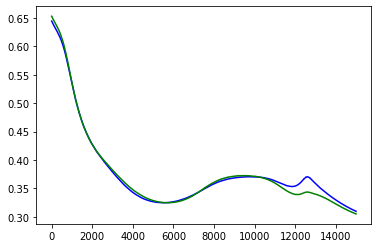

In [9]:
plt.plot(epoches, loss_avg, color='b')
plt.plot(epoches, loss_val, color='g')

Судя по графику, переобучение незначительное (графики функции потерь на тестовых (зеленый) и тренировочных (синий) данных почти совпадают)

Decision Boundary


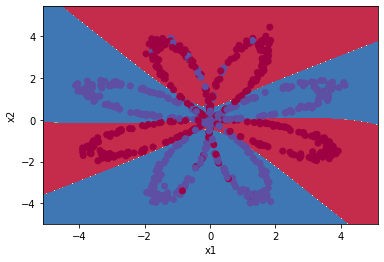

In [10]:
#print("Decision Boundary for train, hidden layer size " + str(model.params['w1'].shape[0]))
print("Decision Boundary")
plot_decision_boundary(lambda x: model(x)>0.5, X_train, y_train)